<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
</head>

# Potential Outcomes Causal Model

## Concepts and examples 

When we use potential outcomes causal model to do research, we will try to
estimate population (or sometime subgroup) mean. The _average treatment 
effect_ (ATE) is defined as

$$
\begin{aligned}
ATE & = E[\sigma_i] \\
    & = E[Y_i^1 - Y_i^0] \\
    & = E[Y_i^1] - E[Y_i^0]
\end{aligned}
$$

ATE can not be calculated(one man cannot live twice) but could be estimated. 

The _average treatment effect for the treatment group_ (ATT) is defined as
follows:

$$
\begin{aligned}
ATT & = E[\sigma_i | D_i = 1] \\
    & = E[Y_i^1 - Y_i^0 | D_i=1] \\ 
    & = E[Y_i^1 |D_i=1] - E[Y_i^0 |D_i=1]
\end{aligned}
$$

The _average treatment effect for the untreatment group_ (ATU) is defined as
follows:


\begin{aligned}
ATT & = E[\sigma_i | D_i = 0] \\
    & = E[Y_i^1 - Y_i^0 | D_i=0] \\ 
    & = E[Y_i^1 |D_i=0] - E[Y_i^0 |D_i=0]
\end{aligned}


It is easy to show that:

\begin{aligned}
E\left[Y^1 \mid D=1\right]-E\left[Y^0 \mid D=0\right] &=A T E \\
&+\left(E\left[Y^0 \mid D=1\right]-E\left[Y^0 \mid D=0\right]\right) \\
&+(1-\pi)(A T T-A T U)
\end{aligned}

Each decomposition has its own name:

\begin{aligned}
\underbrace{\frac{1}{N_T} \sum_{i=1}^n\left(y_i \mid d_i=1\right)-\frac{1}{N_C} \sum_{i=1}^n\left(y_i \mid d_i=0\right)}_{\text {Simple Difference in Outcomes }} &=\underbrace{E\left[Y^1\right]-E\left[Y^0\right]}_{\text {Average Treatment Effect }} \\
&+\underbrace{E\left[Y^0 \mid D=1\right]-E\left[Y^0 \mid D=0\right]}_{\text {Selection bias }} \\
&+\underbrace{(1-\pi)(A T T-A T U)}_{\text {Heterogeneous treatment effect bias }}
\end{aligned}

In [1]:
# load packages 
library(pacman)
p_load(tidyverse, data.table, stats, ri2)
options(dplyr.summarise.inform = FALSE)

In [28]:
po <- tibble(
    y1 = c(7, 5, 5, 7, 4, 10, 1, 5, 3, 9),
    y0 = c(1, 6, 1, 8, 2, 1, 10, 6, 7, 8),
    d = c(1, 0, 1, 0, 1, 1, 0, 0, 0, 1),
    yo = c(7, 6, 5, 8, 4, 10, 10, 6, 7, 9)
)
po

y1,y0,d,yo
<dbl>,<dbl>,<dbl>,<dbl>
7,1,1,7
5,6,0,6
5,1,1,5
7,8,0,8
4,2,1,4
10,1,1,10
1,10,0,10
5,6,0,6
3,7,0,7


In [169]:
po %>%
    summarize(ATE=mean(y1)-mean(y0))  # idea world

ATE
<dbl>
0.6


In [163]:
po %>%
    group_by(d) %>%
    summarize(control_mean = mean(y0)) %>%
    column_to_rownames('d') %>%
    t() %>% as_tibble() %>%
    rename('y0_d1'='1', 'y0_d0'='0') %>%
    mutate(selection_bias=y0_d1 - y0_d0)


y0_d0,y0_d1,selection_bias
<dbl>,<dbl>,<dbl>
7.4,2.6,-4.8


In [168]:
po %>%
    group_by(d) %>%
    summarize(treat_mean=mean(y1), control_mean=mean(y0)) %>%
    mutate(hetergenous_bias=treat_mean-control_mean)

d,treat_mean,control_mean,hetergenous_bias
<dbl>,<dbl>,<dbl>,<dbl>
0,4.2,7.4,-3.2
1,7.0,2.6,4.4


In [171]:
# estimated differences
po %>%
    group_by(d) %>%
    summarize(observed_mean=mean(yo))

d,observed_mean
<dbl>,<dbl>
0,7.4
1,7.0


In [182]:
7.0-7.4

[1] -0.4

In [184]:
0.6 - 4.8 + 0.5*(4.4-(-3.2))

[1] -0.4

## SUTVA 

Stable Unit Treatment Values Assumption (SUTVA) means: 

1. No interference
    * The potential outcomes for any unit do not vary with the treatments assigned to other units
    * A subject’s potential outcome is not affected by other subjects’ exposure to the treatment
2. No hidden variations of treatment
    * For each unit, there are no different forms or versions of each treatment 
    level, which lead to different potential outcomes (Consistency)

## Fisher's Exact Test

![tea-pot](https://upload.wikimedia.org/wikipedia/commons/3/37/Nice_Cup_of_Tea.jpg)

Here we consider the famous tea tasting example! In a summer tea-part in Cambridge,
England, a lady claimed to be able to discern, by taste alone, whether a cup 
of tea with milk had the tea poured first or the milk poured first. An 
experiment was performed by Sir R.A. Fisher himself, then and there, 
to see if her claim was valid. Eight cups of tea were prepared and 
presented to her in random order. Four had the milk poured first, and other 
four had the tea poured first. The lady tasted each one and rendered her opinion. 
The results are summarized in the following $2 \times 2$ table: 

| actual\guess | tea | milk |
|--------------|-----|------|
| tea          | 3   | 1    |
| milk         | 1   | 3    |

We have our null hypothesis $H_0$: the lady is just purely guessing. 

Suppose we have our $8$ cups of tea prepared and we just need to arrange
them and let our 'tea lady' to choose it. For Mr Fisher, he has

$${8 \choose 4} = \frac{8!}{4!4!} = 1680$$

was of combinations. If our tea lady's selection of all four the cups that 
are truly "tea first," then it has

$${4 \choose 4} {4 \choose 0} = 24 $$

choices. Then the probability that she would correctly identify all four cups is

$$\frac{24}{1680} = \frac{1}{70} = 0.014s$$

However, from our table, we have the following probability:

$$\frac{{4 \choose 3}{3 \choose 1}}{{8 \choose 4}} = \frac{16}{70} = 0.229$$

Then in our experiment, the $p$-value is $0.229+0.014=0.243$, which is only 
weak evidence against the null. In other words, there is not enough evidence 
to reject the null hypothesis that the lady is just purely guessing.



In [2]:
tea<- matrix(
    c(3, 1, 1, 3), 
    ncol= 2, 
    dimnames = list(
        Truth = c("Tea","Milk" ),
        Lady_says = c("Tea first","Milk first")
        )
    )
tea

,Tea first,Milk first
Tea,3,1
Milk,1,3


In [3]:
fisher.test(tea, alternative = "greater")


	Fisher's Exact Test for Count Data

data:  tea
p-value = 0.2429
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.3135693       Inf
sample estimates:
odds ratio 
  6.408309 


In [5]:
fisher.test(tea)  # two sides 


	Fisher's Exact Test for Count Data

data:  tea
p-value = 0.4857
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   0.2117329 621.9337505
sample estimates:
odds ratio 
  6.408309 


## Randomization Inference

The way to construct randomization inference is to shuffle the treatment
indicator, which assumes that _any treatment effect is just pure chance_. 

There are six steps to randomization inference: 

1. the choice of the sharp null,
2. the construction of the null,
3. the picking of a different treatment vector,
4. the calculation of the corresponding test statistic for that new treatment vector,
5. the randomization over step 3 as you cycle through a number of new treatment vectors (ideally all possible combinations), and 6. the calculation the exact -value.

In [2]:
# create the simulated example
ex1 <- tibble(
    name=c('Andy', 'Ben', 'Chad', 
                    'Daniel', 'Edith', 'Frank', 'George', 'Hank'),
    treatment=c(rep(1, times=4), rep(0, times=4)),
    outcome=c(10, 5, 16, 3, 5, 7, 8, 10),
    id=c(1:8)
)
ex1

name,treatment,outcome,id
<chr>,<dbl>,<dbl>,<int>
Andy,1,10,1
Ben,1,5,2
Chad,1,16,3
Daniel,1,3,4
Edith,0,5,5
Frank,0,7,6
George,0,8,7
Hank,0,10,8


In [47]:
ex1 %>%
    group_by(treatment) %>%
    summarize(outcome_mean=mean(outcome)) %>%
    t() %>% data.frame() %>%
    setNames(c('control', 'treatment')) %>%
    mutate(diff=treatment-control)

,control,treatment,diff
,<dbl>,<dbl>,<dbl>
treatment,0.0,1.0,1
outcome_mean,7.5,8.5,1


In [106]:
combn(8, 4) %>%  # calculate all possible combinations 
    t() %>% as_tibble() %>%
    transmute(
    treated1 = V1, treated2 = V2,
    treated3 = V3, treated4 = V4) %>% # label them as four columns 
    mutate(permutation = 1:70) %>%  # label all permutation 
    crossing(., ex1) %>%  # combine the dataset
    arrange(permutation, name) %>% 
    mutate(d = case_when(id == treated1 | id == treated2 |
                         id == treated3 | id == treated4 ~ 1,
                       TRUE ~ 0)) -> all_comb

head(all_comb)


treated1,treated2,treated3,treated4,permutation,name,treatment,outcome,id,d
<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,2,3,4,1,Andy,1,10,1,1
1,2,3,4,1,Ben,1,5,2,1
1,2,3,4,1,Chad,1,16,3,1
1,2,3,4,1,Daniel,1,3,4,1
1,2,3,4,1,Edith,0,5,5,0
1,2,3,4,1,Frank,0,7,6,0


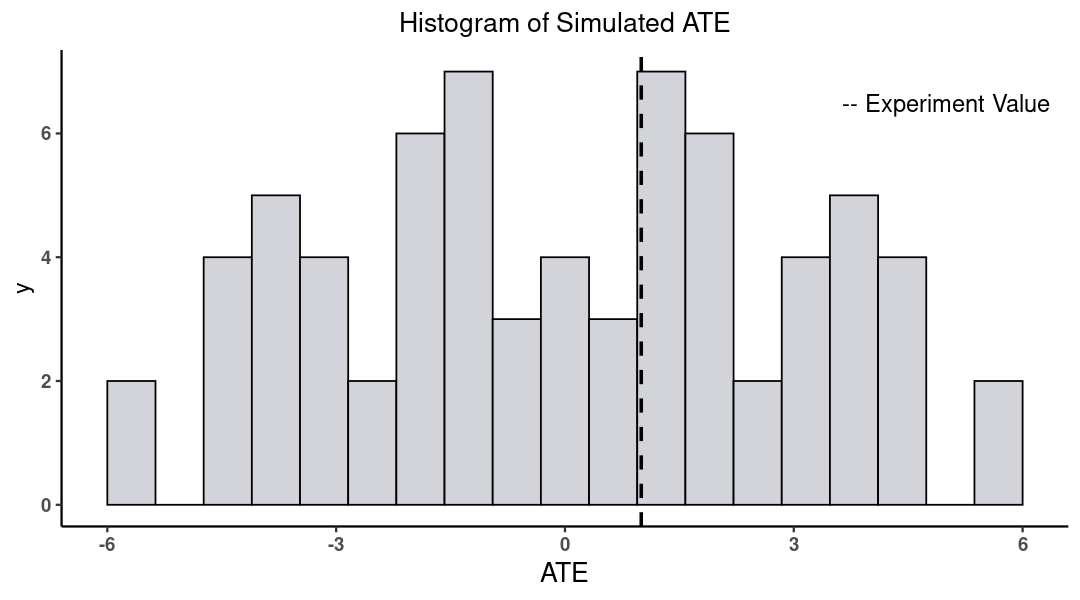

In [279]:
all_comb %>%
    group_by(permutation, d) %>%
    summarize(t_mean=mean(outcome)) %>%
    group_by(d) %>%
    mutate(index=row_number()) %>%
    pivot_wider(
        names_from=d, 
        values_from=t_mean, 
        names_prefix='group_') %>%
    mutate(ate=group_1-group_0) %>%
    arrange(desc(ate)) %>%
    mutate(rank=row_number(), size=nrow(.)) -> sm_data

options(repr.plot.width=9, repr.plot.height=5)  # figsize
sm_data %>%
    ggplot(aes(ate)) + 
    geom_histogram(bins=20, color='black', fill='#D2D4DA') +
    theme_classic(base_size=14) +
    labs(
        title='Histogram of Simulated ATE',
        x='ATE'
        ) + 
    theme(plot.title=element_text(hjust=0.5, size=16),
            axis.text.x=element_text(face='bold'),
            axis.title.x=element_text(size=16),
            axis.text.y=element_text(face='bold')) +
    geom_vline(xintercept=1, linetype='dashed', size=1, show.legend=T) + 
    annotate(geom='label', x=5, y=6.5, label='-- Experiment Value',
            size=5, label.size=NA)

In [172]:
sm_data %>%
    filter(permutation==1) %>%
    mutate(p_value=rank/size)  # one-side 

permutation,index,group_0,group_1,ate,rank,size,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,1,7.5,8.5,1,25,70,0.3571429


In [252]:
# two side test
all_comb %>%
    group_by(permutation, d) %>%
    summarize(t_mean=mean(outcome)) %>%
    group_by(d) %>%
    mutate(index=row_number()) %>%
    pivot_wider(
        names_from=d, 
        values_from=t_mean, 
        names_prefix='group_') %>%
    mutate(ate=group_1-group_0) %>%
    mutate(ate_abs=abs(ate)) %>%
    arrange(desc(ate_abs)) %>%
    mutate(rank=row_number(), size=nrow(.)) %>%
    group_by(ate_abs) %>%
    mutate(new_rank=max(rank)) %>%
    filter(permutation==1) %>%
    mutate(p_value=new_rank/size)


permutation,index,group_0,group_1,ate,ate_abs,rank,size,new_rank,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
1,1,7.5,8.5,1,1,49,70,60,0.8571429


In [96]:
# another way to do it (pivot_wider is better)
te1 <- all_comb %>%
            group_by(permutation) %>%
            filter(d==1) %>%
            summarize(te1=mean(outcome))
te0 <- all_comb %>%
            group_by(permutation) %>%
            filter(d==0) %>%
            summarize(te0=mean(outcome))
inner_join(te1, te0, by = "permutation") %>%
        mutate(ate = te1 - te0) %>% 
        select(permutation, ate) %>% 
        arrange(desc(ate)) %>% 
        mutate(rank = 1:nrow(.), size=nrow(.)) %>% 
        filter(permutation==1) %>%  # data from the experiment
        mutate(p_value=rank/size)

permutation,ate,rank,size,p_value
<int>,<dbl>,<int>,<int>,<dbl>
1,1,25,70,0.3571429


Since the $p$-value is $0.357$, we cannot reject the null hypothesis that
the treatment effect is pure chance. However, when we use this kind of test,
we need to be careful about _outliers_. Outliers create problems for that test 
statistic because of the variation that gets introduced in the 
randomization distribution. So other alternative test statistics 
become more attractive.

But all of these test statistics we’ve been discussing have been differences 
in the outcomes by treatment status. We considered simple differences in 
averages, simple differences in log averages, differences in quantiles, 
and differences in ranks. Imbens and Rubin (2015) note that there are shortcomings 
that come from focusing solely on a few features of the data (e.g., skewness), 
as it can cause us to miss differences in other aspects. This specifically 
can be problematic if the variance in potential outcomes for the treatment group 
differs from that of the control group. Focusing only on the simple average 
differences we discussed may not generate $p$-values that are “extreme” 
enough to reject the null even when the null in fact does not hold. 
So we may be interested in a test statistic that can detect differences 
in distributions between the treatment and control units. One such test 
statistic is the Kolmogorov-Smirnov test statistic.

Let's first define the empirical cumulative distribution function (CDF) as:
$$
\begin{aligned}
\widehat{F}_C(Y) &=\frac{1}{N_C} \sum_{i: D_i=0} 1\left(Y_i \leq Y\right) \\
\widehat{F}_T(Y) &=\frac{1}{N_T} \sum_{i: D_i=1} 1\left(Y_i \leq Y\right)
\end{aligned}
$$

If two distributions are the same, then their empirical CDF is the same. 
But note, empirical CDFs are functions, and test statistics are scalars. 
So how will we take differences between two functions and turn that 
into a single scalar quantity? Easy—we will use the maximum difference 
between the two empirical CDFs. Visually, it will literally be the 
greatest vertical distance between the two empirical CDFs. That vertical 
distance will be our test statistic. Formally it is:

$$T_{KS}=\max |\widehat{F}_T(Y_i) - \widehat{F}_C(Y_i) | $$

In [3]:
# the simulation
tb <- tibble(
  d = c(rep(0, 20), rep(1, 20)),
  y = c(0.22, -0.87, -2.39, -1.79, 0.37, -1.54, 
        1.28, -0.31, -0.74, 1.72, 
        0.38, -0.17, -0.62, -1.10, 0.30, 
        0.15, 2.30, 0.19, -0.50, -0.9,
        -5.13, -2.19, 2.43, -3.83, 0.5, 
        -3.25, 4.32, 1.63, 5.18, -0.43, 
        7.11, 4.87, -3.10, -5.81, 3.76, 
        6.31, 2.58, 0.07, 5.76, 3.50)
)
cbind(head(tb), tail(tb))

d,y,d,y
<dbl>,<dbl>,<dbl>,<dbl>
0,0.22,1,3.76
0,-0.87,1,6.31
0,-2.39,1,2.58
0,-1.79,1,0.07
0,0.37,1,5.76
0,-1.54,1,3.50


In [270]:
kdensity_d1 <- tb %>%
  filter(d == 1) %>% 
  pull(y)
kdensity_d1 <- density(kdensity_d1)

kdensity_d0 <- tb %>%
  filter(d == 0) %>% 
  pull(y)
kdensity_d0 <- density(kdensity_d0)
kdensity_d0 <- tibble(x=kdensity_d0$x, y=kdensity_d0$y, d=0)
kdensity_d1 <- tibble(x=kdensity_d1$x, y=kdensity_d1$y, d=1)
kdensity <- rbind(kdensity_d0, kdensity_d1)
kdensity$d <- as_factor(kdensity$d)

cbind(head(kdensity), tail(kdensity))

x,y,d,x,y,d
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>
-3.712577,0.0005116173,0,12.80964,0.0002382012,1
-3.698222,0.0005648645,0,12.85818,0.0002206892,1
-3.683868,0.0006218184,0,12.90672,0.0002049130,1
-3.669513,0.0006826713,0,12.95526,0.0001897534,1
-3.655159,0.0007513811,0,13.00380,0.0001757694,1
-3.640804,0.0008246849,0,13.05234,0.0001627873,1


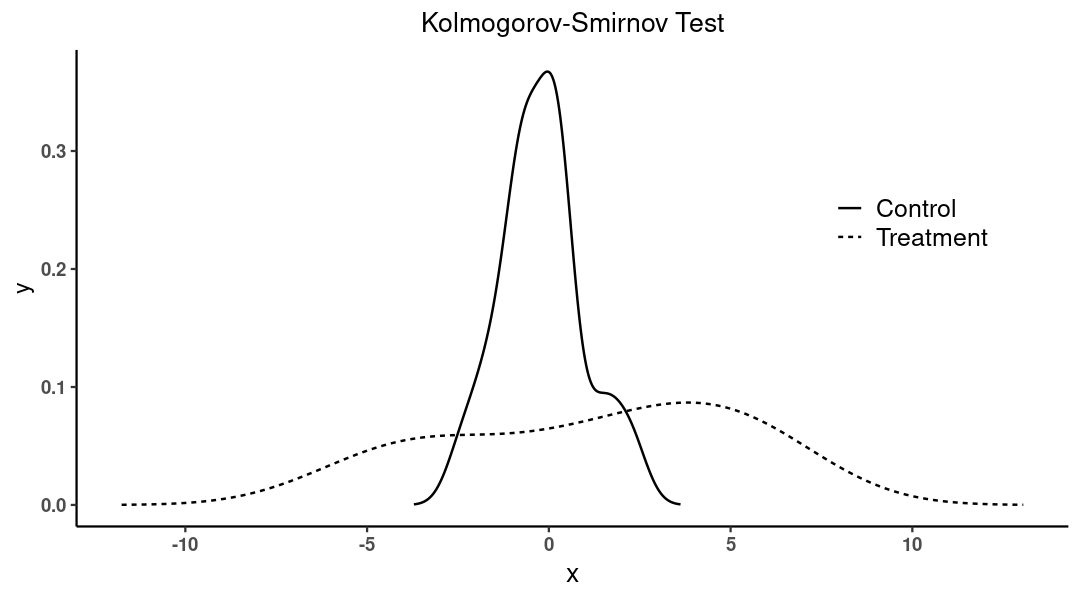

In [313]:
kdensity %>%
  ggplot()+ 
  geom_line(size = 0.7, aes(x,y, linetype=d))+
  labs(title = "Kolmogorov-Smirnov Test")+
  scale_linetype_discrete(labels=c('Control', 'Treatment'))+
  theme_classic(base_size=14) + 
  theme(plot.title=element_text(hjust=0.5, size=16),
            axis.text.x=element_text(face='bold'),
            axis.title.x=element_text(size=16),
            axis.text.y=element_text(face='bold'),
            legend.title=element_blank(),
            legend.text = element_text(size=15),
            legend.position=c(0.84, 0.65)) + 
  guides(linetype=guide_legend(nrow = 2))

If we do RI with the data from above using the simple difference as test statistic, 
we can’t reject the sharp null of having zero effect for all the units, 
despite having two evidently different outcome distributions.

In [5]:
# calculate p-value for the data=tb by using absolute difference
# Declaring the `test_function`
sd <- function(data) {
  # it receives a dataframe
  data %>% 
  summarise(te1 = mean(y[d == 1], na.rm=TRUE),
            te0 = mean(y[d == 0], na.rm=TRUE),
            sdo = te1 - te0) %>% 
    # and returns a scalar
    pull(sdo)
}

set.seed(666)

conduct_ri(
  test_function = sd,
  assignment = "d",
  outcome = "y",
  declaration = declare_ra(N = 40, m = 20),
  sharp_hypothesis = 0,
  data = tb,
  sims = 5000  # simulate 5000 times
)

                   term estimate two_tailed_p_value
1 Custom Test Statistic    1.415              0.139

In [7]:
# ks statistics 
ks_statistic <- function(data) {
  
  control <- data[data$d == 0, ]$y
  treated <- data[data$d == 1, ]$y
  
  cdf1 <- ecdf(control)  # empirical cumulate density function 
  cdf2 <- ecdf(treated)
  
  # construct the common base for x-axis 
  minMax <- seq(min(control, treated),
                max(control, treated),
                length.out=length(c(control, treated))) 
  
  # find the x-value that has the largest vertical difference
  # between two ecdf 
  x0 <-
    minMax[which(
        abs(
            cdf1(minMax) - cdf2(minMax)
            ) == max(
                abs(cdf1(minMax) - cdf2(minMax))
                )
            )]
  
  y0 <- cdf1(x0)
  y1 <- cdf2(x0) 
  
  diff <- unique(abs(y0 - y1))
  
  diff
  
}

set.seed(667)

conduct_ri(
  test_function = ks_statistic,
  assignment = "d",
  outcome = "y",
  declaration = declare_ra(N = 40, m = 20),
  sharp_hypothesis = 0,
  data = tb,
  sims = 5000  # simulate 5000 times
)

                   term estimate two_tailed_p_value
1 Custom Test Statistic     0.45              0.023

We can see that _KS_ test will reject the null hypothesis, whereas simple
difference will not. 

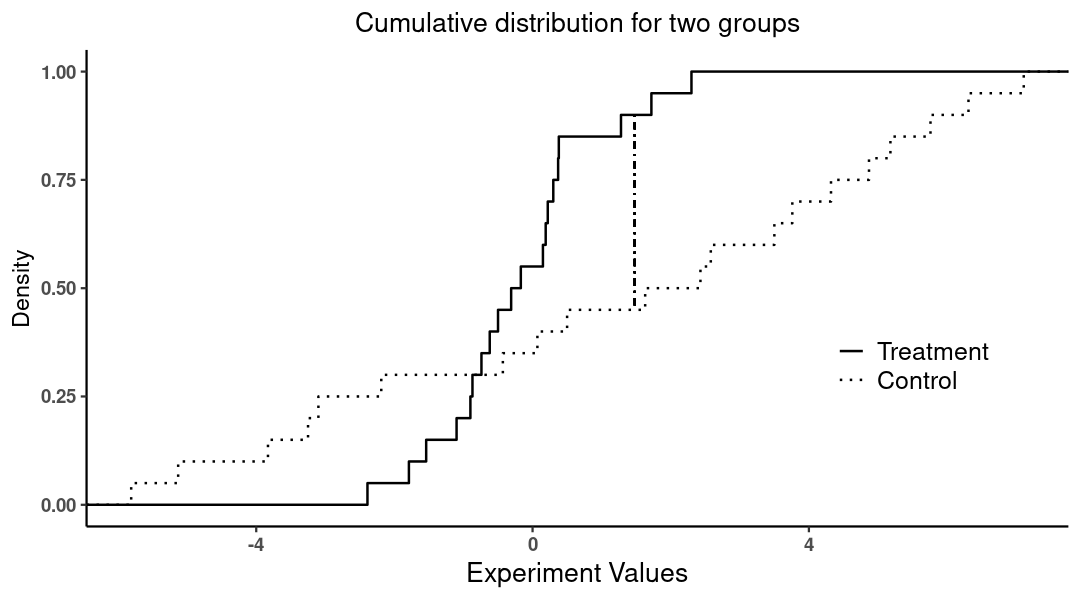

In [42]:
# plot the ecdf and ks statistics
# calculate ks 
cdf1 <- ecdf(tb[tb$d==1, ]$y)  # ecdf function for treatment group
cdf0 <- ecdf(tb[tb$d==0, ]$y)  # for control group
xaxis_seq <- seq(min(tb$y), max(tb$y), length.out=length(tb$y))

# find the value (location) on x-axis that gives the largest distance
x_max <- xaxis_seq[which(
    abs(
        cdf1(xaxis_seq) - cdf2(xaxis_seq)
        ) == max(
            abs(cdf1(xaxis_seq) - cdf2(xaxis_seq))
        )
)]

y1 <- cdf1(x_max)
y0 <- cdf0(x_max)

tb %>% 
    ggplot(aes(y)) + 
    stat_ecdf(
        aes(linetype=factor(d)),
        geom = "step",
        size=0.7
        ) + 
    scale_linetype_manual(
        values=c('solid', 'dotted'),
        labels=c('Treatment', 'Control')
        ) + 
    labs(
        x='Experiment Values',
        y='Density',
        title='Cumulative distribution for two groups'
    ) + 
    geom_segment(
        aes(x=x_max, y=y0, xend=x_max, yend=y1),
        linetype='dotdash'
    ) + 
    theme_classic(base_size=14) +
    theme(plot.title=element_text(hjust=0.5, size=16),
            axis.text.x=element_text(face='bold'),
            axis.title.x=element_text(size=16),
            axis.text.y=element_text(face='bold'),
            legend.title=element_blank(),
            legend.text = element_text(size=15),
            legend.position=c(0.84, 0.35))

## References

1. [Fisher's Exact Test](https://online.stat.psu.edu/stat504/lesson/4/4.5)
2. [Randomization in R](https://www.franciscoyira.com/post/randomization-inference-causal-mixtape/)